In [11]:
sub_path = '/tmp/working/IEEE_Fraud_Detection/data/output/'

import numpy as np
import pandas as pd 
import datetime

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
all_files = []

# all_files.append(sub_path + 'sub_201908270710_lgb_dart_0.9506.csv') # lgbm dart
# all_files.append(sub_path + 'sub_201908262358_lgb_gbdt_0.9499.csv') # lgbm standard
all_files.append(sub_path + 'catoost_submission_2_0.9406.csv')             # catboost
all_files.append(sub_path + 'sub_201909301902_lgb_0.9402.csv') # lgbm small num_leaves
all_files.append(sub_path + 'sub_201909262359_lgb_0.9429.csv') # lgbm large num_leaves
# all_files.append(sub_path + 'sub_201909072232_xgb_0.9454.csv') # xgb standard
# all_files.append(sub_path + 'nn_submission_0.9200.csv')  # NN 
# all_files.append(sub_path + 'sub_201909110005_cat_0.9237.csv') # catboost at local

In [13]:
scores = np.zeros(len(all_files))
for i in range(len(all_files)):
    scores[i] = float('.'+all_files[i].split(".")[1])

In [14]:
top = scores.argsort()[::-1]
for i, f in enumerate(top):
    print(i,scores[f],all_files[f])

0 0.9429 /tmp/working/IEEE_Fraud_Detection/data/output/sub_201909262359_lgb_0.9429.csv
1 0.9406 /tmp/working/IEEE_Fraud_Detection/data/output/catoost_submission_2_0.9406.csv
2 0.9402 /tmp/working/IEEE_Fraud_Detection/data/output/sub_201909301902_lgb_0.9402.csv


In [15]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in top]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols

In [16]:
concat_sub.describe()

,m0,m1,m2
count,506691.000000,506691.000000,506691.000000
mean,0.018034,0.027818,0.025198
std,0.104769,0.120339,0.110090
min,0.000046,0.000014,0.000054
25%,0.000498,0.001013,0.001406
50%,0.001118,0.002911,0.003351
75%,0.002984,0.008729,0.009047
max,0.997982,0.999933,0.998627


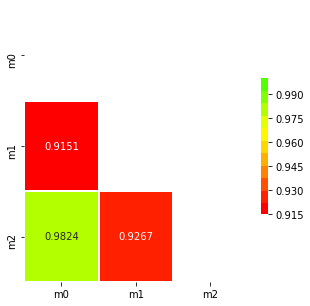

In [17]:
# check correlation
corr = concat_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.5})


In [18]:
# # rank averaging
# for i in range(concat_sub.shape[1]):
#     concat_sub['m' + str(i) + 'rank'] = concat_sub['m' + str(i)].rank()
    
# for i in range(int(concat_sub.shape[1] / 2)):
#     concat_sub.drop('m' + str(i), axis=1, inplace=True)
    
# concat_sub = concat_sub / concat_sub.shape[0]

In [19]:
concat_sub['isFraud'] = concat_sub.sum(axis=1)
concat_sub.head()

,m0,m1,m2,isFraud
TransactionID,,,,
3663549,0.000344,0.000169,0.000882,0.001394
3663550,0.000729,0.002175,0.002198,0.005102
3663551,0.000637,0.000651,0.001514,0.002803
3663552,0.000365,0.000374,0.001272,0.002011
3663553,0.000922,0.002469,0.001969,0.005360


In [20]:
now = datetime.datetime.now()
concat_sub[['isFraud']].to_csv(
    '/tmp/working/IEEE_Fraud_Detection/data/output/sub_blended_{0:%Y%m%d%H%M}.csv'.format(now),
)

In [38]:
mean_corr = corr.mean()
mean_corr = mean_corr.sort_values(ascending=True)
mean_corr = mean_corr[:5]a
mean_corr

m5    0.932314
m4    0.973947
m3    0.976223
m1    0.976957
m2    0.978094
dtype: float64

In [39]:
m_gmean1 = 0
for n in mean_corr.index:
    m_gmean1 += np.log(concat_sub[n])
m_gmean1 = np.exp(m_gmean1/len(mean_corr))

In [43]:
rank = np.tril(corr.values,-1)
rank[rank<0.94] = 1
m = (rank>0).sum() - (rank>0.99).sum()
m_gmean2, s = 0, 0
for n in range(m):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/m
    m_gmean2 += w*(np.log(concat_sub.iloc[:,mx[0]])+np.log(concat_sub.iloc[:,mx[1]]))/2
    s += w
    rank[mx] = 1
m_gmean2 = np.exp(m_gmean2/s)

In [58]:
top

array([0, 1, 4, 3, 2])

In [44]:
top_mean = 0
s = 0
for n in [0,1,2,3,4]:
    top_mean += concat_sub.iloc[:,n]*scores[top[n]]
    s += scores[top[n]]
top_mean /= s


In [56]:
m_gmean = np.exp(0.5*np.log(m_gmean1)  + 0.5*np.log(top_mean))

In [57]:
concat_sub['isFraud'] = m_gmean
now = datetime.datetime.now()
concat_sub[['isFraud']].to_csv(
    '/tmp/working/IEEE_Fraud_Detection/data/output/sub_blended_{0:%Y%m%d%H%M}.csv'.format(now),
)

In [53]:
m_gmean

TransactionID
3663549    0.000551
3663550    0.001674
3663551    0.000898
3663552    0.000593
3663553    0.001572
             ...   
4170235    0.004704
4170236    0.003025
4170237    0.002693
4170238    0.002791
4170239    0.002238
Length: 506691, dtype: float64

In [8]:
import pandas as pd
sub_dict = {}
sub_dict['sub1'] = pd.read_csv(sub_path + 'sub_201908270710_lgb_dart_0.9506.csv') # lgbm dart
sub_dict['sub2'] = pd.read_csv(sub_path + 'sub_201908262358_lgb_gbdt_0.9499.csv') # lgbm standard
sub_dict['sub3'] = pd.read_csv(sub_path + 'catoost_submission_2_0.9406.csv')             # catboost
sub_dict['sub4'] = pd.read_csv(sub_path + 'sub_201909061911_lgb_gbdt_0.9460.csv') # lgbm small num_leaves
sub_dict['sub5'] = pd.read_csv(sub_path + 'sub_201909071300_lgb_gbdt_0.9466.csv') # lgbm large num_leaves

sample = pd.read_csv('/tmp/working/IEEE_Fraud_Detection/data/input/sample_submission.csv')

In [10]:
sub_dict['sub1']['isFraud'].max(), sub_dict['sub2']['isFraud'].max(), sub_dict['sub3']['isFraud'].max(), sub_dict['sub4']['isFraud'].max(), sub_dict['sub5']['isFraud'].max()

(0.9996521433213272,
 0.9984111142787484,
 0.9999331464134232,
 0.999064814024606,
 0.997100167485048)

In [21]:
outs = [sub['isFraud'] for sub in sub_dict.values()]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x+1), range(len(concat_sub.columns))))
concat_sub.columns = cols

In [22]:
concat_sub.head()

,m1,m2,m3,m4,m5
0,0.000445,0.000456,0.000169,0.000964,0.000732
1,0.000984,0.001115,0.002175,0.002811,0.001495
2,0.000770,0.001008,0.000651,0.000785,0.001353
3,0.000343,0.000418,0.000374,0.000970,0.000905
4,0.000755,0.001208,0.002469,0.002522,0.001300


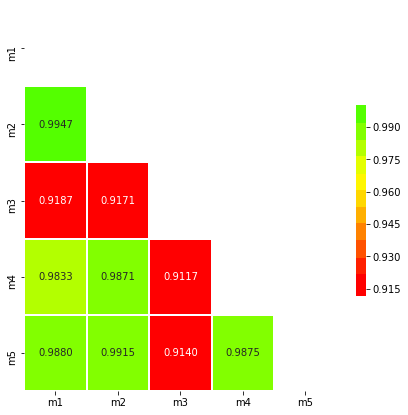

In [23]:
# check correlation
corr = concat_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.5})

In [24]:
mean_corr = corr.mean()
mean_corr = mean_corr.sort_values(ascending=True)
mean_corr = mean_corr[:5]
mean_corr

m3    0.932314
m4    0.973947
m5    0.976223
m1    0.976957
m2    0.978094
dtype: float64

In [25]:
m_gmean1 = 0
for n in mean_corr.index:
    m_gmean1 += np.log(concat_sub[n])
m_gmean1 = np.exp(m_gmean1/len(mean_corr))

In [30]:
rank = np.tril(corr.values,-1)
rank[rank<0.94] = 1
rank
m = (rank>0).sum() - (rank>0.97).sum()
m
m_gmean2, s = 0, 0
for n in range(m):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/m
    m_gmean2 += w*(np.log(concat_sub.iloc[:,mx[0]])+np.log(concat_sub.iloc[:,mx[1]]))/2
    s += w
    rank[mx] = 1
m_gmean2 = np.exp(m_gmean2/s)

ZeroDivisionError: division by zero

In [16]:
sample['isFraud'] = sub3['isFraud'] + sub4['isFraud'] + sub5['isFraud']

In [17]:
now = datetime.datetime.now()
sample.to_csv(
    '/tmp/working/IEEE_Fraud_Detection/data/output/sub_blended_{0:%Y%m%d%H%M}.csv'.format(now),
    index=False
)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sub1['isFraud'].plot(kind='hist', bins=200, figsize=(15,5), title='Prediction')
plt.xlim((0.5, 1.1))
plt.ylim((0, 20000))
plt.xticks(np.arange(0.0, 1, 0.02), rotation=90)
plt.show();

In [ ]:
sub2['isFraud'].plot(kind='hist', bins=200, figsize=(15,5), title='Prediction')
plt.xlim((0.5, 1.1))
plt.ylim((0, 20000))
plt.xticks(np.arange(0., 1, 0.02), rotation=90)
plt.show();

In [ ]:
sub1[sub1['isFraud'] > 0.5]['isFraud'].plot(kind='hist', bins=200, figsize=(15,5), title='Prediction')
plt.xticks(np.arange(0, 1, 0.02), rotation=90)
plt.show();

In [ ]:
sub3 = pd.concat([sub1, sub2['isFraud']], axis=1)
sub3.columns=['TransactionID', 'isFraud', 'isFraud2']
sub3.head()

In [ ]:
sub3.loc[sub3['isFraud2'] > 0.8, 'isFraud'] = sub3['isFraud2']

In [ ]:
sub3['isFraud'].plot(kind='hist', bins=50, figsize=(15,5), title='Prediction')
plt.xticks(np.arange(0, 1, 0.05))
plt.show();

In [ ]:
sub4 = sub3[['TransactionID', 'isFraud']]
sub4.head()

In [ ]:
now = datetime.datetime.now()

sub4.to_csv(
    '/tmp/working/IEEE_Fraud_Detection/data/output/sub_blended_{0:%Y%m%d%H%M}.csv'.format(now),
    index=False
)

In [ ]:
sub4['isFraud'].plot(kind='hist', bins=200, figsize=(15,5), title='Prediction')
plt.xticks(np.arange(0, 1, 0.02), rotation=90)
plt.show();